# Other Samplers

Trey V. Wenger (c) February 2025

Here we demonstrate the use of non-standard samplers with `bayes_spec`.

In [1]:
# General imports    
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc as pm

import pymc
print("pymc version:", pymc.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.20.0
bayes_spec version: 1.7.3-staging+2.gc675eaf.dirty


## Data Format

In [2]:
from bayes_spec import SpecData

# spectral axis definition
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 1.0 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(velocity_axis)) # K

# Our model only expects a single observation named "observation"
# Note that because we "named" the spectrum "observation" here,
# we must use the same name in the model definition above
observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

## Simulating Data

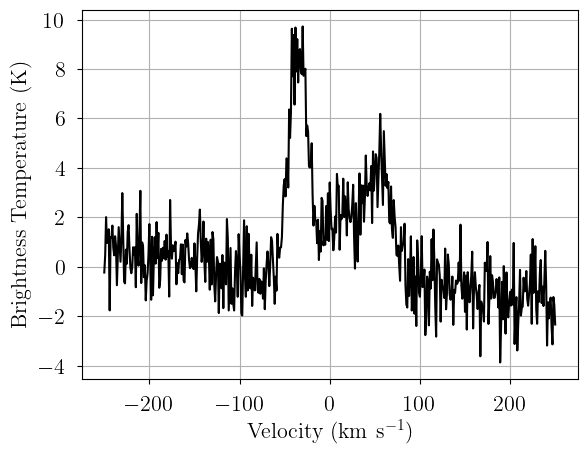

In [3]:
from bayes_spec.models import GaussNoiseModel

# Initialize and define the model
model = GaussNoiseModel(dummy_data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.add_priors(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 1.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

# Simulate observation
sim_brightness = model.model.observation.eval({
    "fwhm": [25.0, 40.0, 35.0], # FWHM line width (km/s)
    "line_area": [250.0, 125.0, 175.0], # line area (K km/s)
    "velocity": [-35.0, 10.0, 55.0], # velocity (km/s)
    "baseline_observation_norm": [-0.5, -2.0, 3.0], # normalized baseline coefficients
    "rms_observation": noise, # spectral rms (K)
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [4]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## MCMC

First, let's revisit the NUTS sampler used in the other notebooks.

In [5]:
model = GaussNoiseModel(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

Let's try the `pymc` `"auto"` initialization.

In [6]:
model.sample(
    init = "auto",
    tune = 1000,
    draws = 1000,
    chains = 4,
    cores = 4,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


Adding log-likelihood to trace


Output()

In [7]:
model.solve()

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [1 2 0]
Chain 1 order: [1 2 0]
Chain 2 order: [1 0 2]
Chain 3 order: [1 2 0]
Adopting (first) most common order: [1 2 0]


Sampling: [observation]


Output()

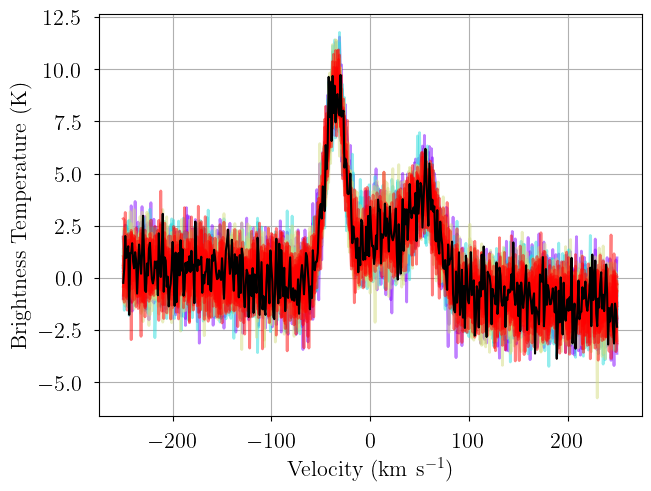

In [8]:
from bayes_spec.plots import plot_predictive

posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

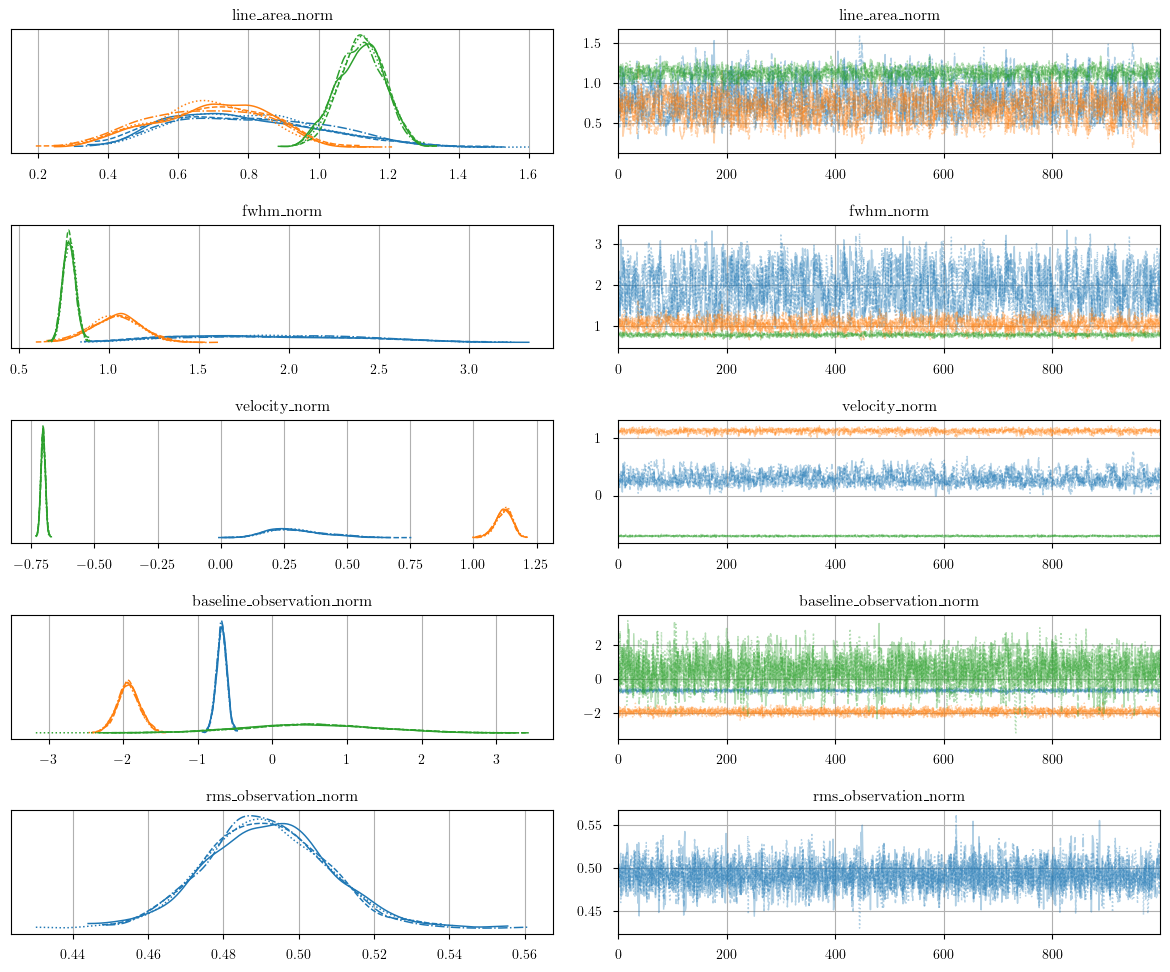

In [9]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

In [10]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
baseline_observation_norm[0]   -0.682   0.069   -0.826   -0.566      0.001   
baseline_observation_norm[1]   -1.928   0.149   -2.204   -1.631      0.002   
baseline_observation_norm[2]    0.517   0.867   -1.017    2.195      0.017   
velocity_norm[0]                0.299   0.112    0.115    0.517      0.003   
velocity_norm[1]                1.120   0.032    1.055    1.174      0.001   
velocity_norm[2]               -0.703   0.009   -0.719   -0.687      0.000   
line_area_norm[0]               0.797   0.210    0.432    1.171      0.007   
line_area_norm[1]               0.684   0.159    0.389    0.955      0.005   
line_area_norm[2]               1.121   0.066    0.991    1.238      0.002   
fwhm_norm[0]                    1.898   0.492    1.046    2.744      0.016   
fwhm_norm[1]                    1.040   0.136    0.778    1.290      0.004   
fwhm_norm[2]                    0.780   0.035    0.719    0.847      0.001   
rms_observation_norm            0.491   0.016    0.460    0.518      0.000   
line_area[0]                  159.382  42.014   86.384  234.165      1.423   
line_area[1]                  136.827  31.832   77.743  190.919      1.062   
line_area[2]                  224.208  13.126  198.187  247.628      0.346   
fwhm[0]                        56.926  14.757   31.372   82.311      0.484   
fwhm[1]                        31.190   4.089   23.335   38.701      0.117   
fwhm[2]                        23.412   1.037   21.560   25.415      0.023   
velocity[0]                    14.943   5.584    5.727   25.848      0.171   
velocity[1]                    55.994   1.617   52.735   58.709      0.044   
velocity[2]                   -35.151   0.433  -35.951  -34.341      0.009   
amplitude[0]                    2.640   0.235    2.215    3.086      0.004   
amplitude[1]                    4.081   0.588    2.946    5.037      0.018   
amplitude[2]                    8.997   0.365    8.310    9.689      0.007   
rms_observation                 0.983   0.032    0.920    1.037      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
baseline_observation_norm[0]    0.001    2713.0    2767.0    1.0  
baseline_observation_norm[1]    0.002    4140.0    2841.0    1.0  
baseline_observation_norm[2]    0.012    2782.0    2788.0    1.0  
velocity_norm[0]                0.002    1115.0    1618.0    1.0  
velocity_norm[1]                0.001    1380.0    2046.0    1.0  
velocity_norm[2]                0.000    2508.0    2655.0    1.0  
line_area_norm[0]               0.005     899.0    2066.0    1.0  
line_area_norm[1]               0.004     915.0    1647.0    1.0  
line_area_norm[2]               0.001    1456.0    2470.0    1.0  
fwhm_norm[0]                    0.011     979.0    2092.0    1.0  
fwhm_norm[1]                    0.003    1214.0    1588.0    1.0  
fwhm_norm[2]                    0.001    2054.0    2835.0    1.0  
rms_observation_norm            0.000    4261.0    2811.0    1.0  
line_area[0]                    1.006     899.0    2066.0    1.0  
line_area[1]                    0.751     915.0    1647.0    1.0  
line_area[2]                    0.244    1456.0    2470.0    1.0  
fwhm[0]                         0.342     979.0    2092.0    1.0  
fwhm[1]                         0.083    1214.0    1588.0    1.0  
fwhm[2]                         0.016    2054.0    2835.0    1.0  
velocity[0]                     0.122    1115.0    1618.0    1.0  
velocity[1]                     0.031    1380.0    2046.0    1.0  
velocity[2]                     0.006    2508.0    2655.0    1.0  
amplitude[0]                    0.003    3184.0    2947.0    1.0  
amplitude[1]                    0.013    1087.0    2117.0    1.0  
amplitude[2]                    0.005    2566.0    2981.0    1.0  
rms_observation                 0.000    4261.0    2811.0    1.0

## `nutpie`

`nutpie` is a NUTS sampler written in RUST that runs on the CPU. It's much faster than the default `pymc` implementation, but there is less control over its initialization (i.e., we can't initialize it using variational inference).

In [11]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "nutpie",
)

/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.12/site-packages/pymc/pytensorf.py:1066: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.12/site-packages/pymc/pytensorf.py:1066: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(


Adding log-likelihood to trace


Output()

After a brief delay while the model is compiled, the sampling begins. Note the speed!

In [12]:
model.solve()

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [0 2 1]
Chain 1 order: [2 0 1]
Chain 2 order: [2 1 0]
Chain 3 order: [1 2 0]
Chain 4 order: [2 1 0]
Chain 5 order: [1 0 2]
Adopting (first) most common order: [2 1 0]


Sampling: [observation]


Output()

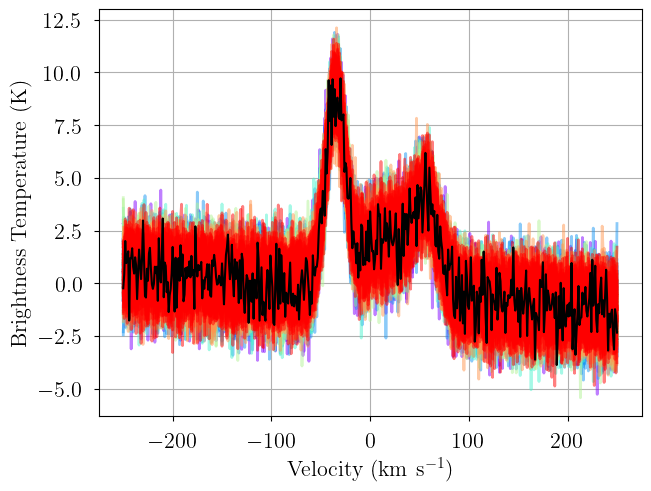

In [13]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

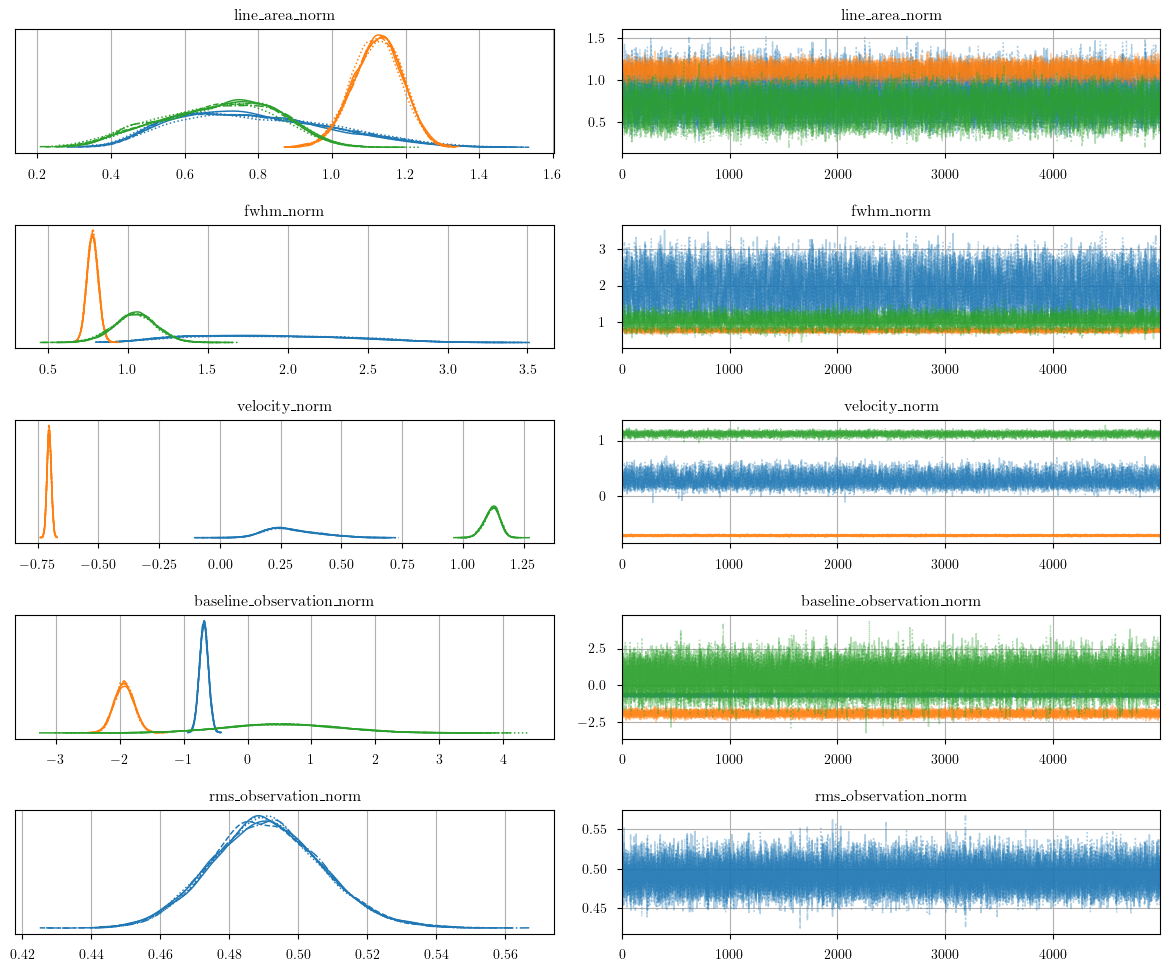

In [14]:
axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

In [15]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
baseline_observation_norm[0]   -0.683   0.070   -0.814   -0.549      0.000   
baseline_observation_norm[1]   -1.931   0.154   -2.220   -1.646      0.001   
baseline_observation_norm[2]    0.541   0.871   -1.065    2.189      0.006   
line_area_norm_log__[0]        -0.159   0.292   -0.694    0.228      0.081   
line_area_norm_log__[1]        -0.188   0.306   -0.735    0.231      0.091   
line_area_norm_log__[2]        -0.208   0.310   -0.760    0.232      0.094   
fwhm_norm_log__[0]              0.225   0.436   -0.327    0.947      0.159   
fwhm_norm_log__[1]              0.126   0.391   -0.337    0.890      0.144   
fwhm_norm_log__[2]              0.032   0.315   -0.360    0.744      0.114   
velocity_norm[0]                0.295   0.109    0.113    0.510      0.002   
velocity_norm[1]               -0.703   0.009   -0.719   -0.686      0.000   
velocity_norm[2]                1.120   0.032    1.060    1.179      0.000   
rms_observation_norm_log__     -0.712   0.032   -0.772   -0.650      0.000   
line_area_norm[0]               0.789   0.206    0.437    1.165      0.003   
line_area_norm[1]               1.123   0.066    1.002    1.247      0.001   
line_area_norm[2]               0.691   0.156    0.403    0.964      0.002   
fwhm_norm[0]                    1.879   0.487    1.050    2.739      0.007   
fwhm_norm[1]                    0.781   0.035    0.713    0.844      0.000   
fwhm_norm[2]                    1.044   0.134    0.788    1.297      0.002   
rms_observation_norm            0.491   0.016    0.462    0.522      0.000   
line_area[0]                  157.880  41.289   87.319  233.024      0.637   
line_area[1]                  224.517  13.167  200.435  249.420      0.146   
line_area[2]                  138.216  31.265   80.656  192.755      0.486   
fwhm[0]                        56.366  14.611   31.494   82.171      0.218   
fwhm[1]                        23.422   1.049   21.383   25.321      0.009   
fwhm[2]                        31.327   4.027   23.641   38.922      0.055   
velocity[0]                    14.747   5.427    5.674   25.519      0.076   
velocity[1]                   -35.140   0.443  -35.943  -34.282      0.003   
velocity[2]                    55.976   1.599   53.001   58.975      0.019   
amplitude[0]                    2.642   0.230    2.208    3.072      0.001   
amplitude[1]                    9.006   0.352    8.329    9.650      0.003   
amplitude[2]                    4.107   0.576    2.997    5.038      0.008   
rms_observation                 0.982   0.032    0.923    1.043      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
baseline_observation_norm[0]    0.000   21783.0   20920.0   1.00  
baseline_observation_norm[1]    0.001   37529.0   22598.0   1.00  
baseline_observation_norm[2]    0.004   24516.0   22739.0   1.00  
line_area_norm_log__[0]         0.059      13.0     291.0   1.37  
line_area_norm_log__[1]         0.066      11.0     136.0   1.47  
line_area_norm_log__[2]         0.069      11.0      94.0   1.52  
fwhm_norm_log__[0]              0.117       8.0      75.0   1.88  
fwhm_norm_log__[1]              0.106       8.0      65.0   2.01  
fwhm_norm_log__[2]              0.084       8.0      24.0   1.93  
velocity_norm[0]                0.001    5562.0    9017.0   1.00  
velocity_norm[1]                0.000   17614.0   20279.0   1.00  
velocity_norm[2]                0.000    7606.0   14188.0   1.00  
rms_observation_norm_log__      0.000   36333.0   22447.0   1.00  
line_area_norm[0]               0.002    4317.0   10719.0   1.00  
line_area_norm[1]               0.001    8085.0   14387.0   1.00  
line_area_norm[2]               0.002    4252.0    7776.0   1.00  
fwhm_norm[0]                    0.005    4575.0   11878.0   1.00  
fwhm_norm[1]                    0.000   12871.0   17687.0   1.00  
fwhm_norm[2]                    0.001    5350.0    8670.0   1.00  
rms_observation_norm            0.000   

## `numpyro`

`numpyro` is a JAX-based NUTS sampler, and it can run on the GPU. `bayes_spec` provides installation options to suport CUDA GPUs (i.e., nvidia). GPUs aren't usually the way to go, unless you have a lot of them! Otherwise, you'll have to run each chain sequentially. Let's stick to the CPU.

In [16]:
import jax
jax.config.update('jax_platform_name', 'cpu')

import numpyro
numpyro.set_platform('cpu')
numpyro.set_host_device_count(6)

In [17]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "numpyro",
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Adding log-likelihood to trace


Output()

In [18]:
model.solve()

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [0 1 2]
Chain 1 order: [2 1 0]
Chain 2 order: [2 1 0]
Chain 3 order: [2 0 1]
Chain 4 order: [1 2 0]
Chain 5 order: [0 1 2]
Adopting (first) most common order: [0 1 2]


Sampling: [observation]


Output()

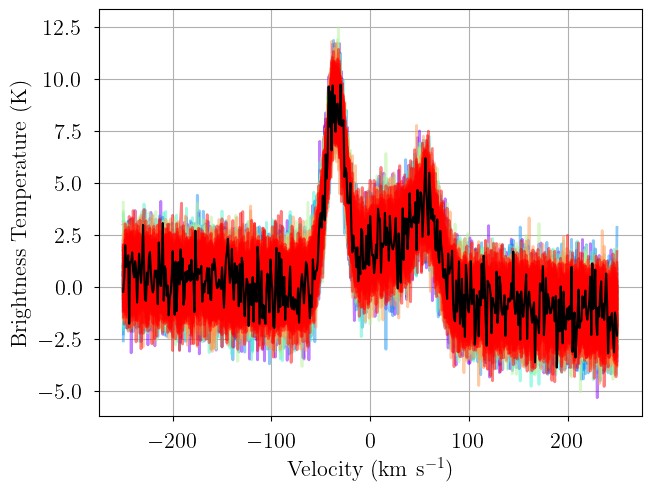

In [19]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

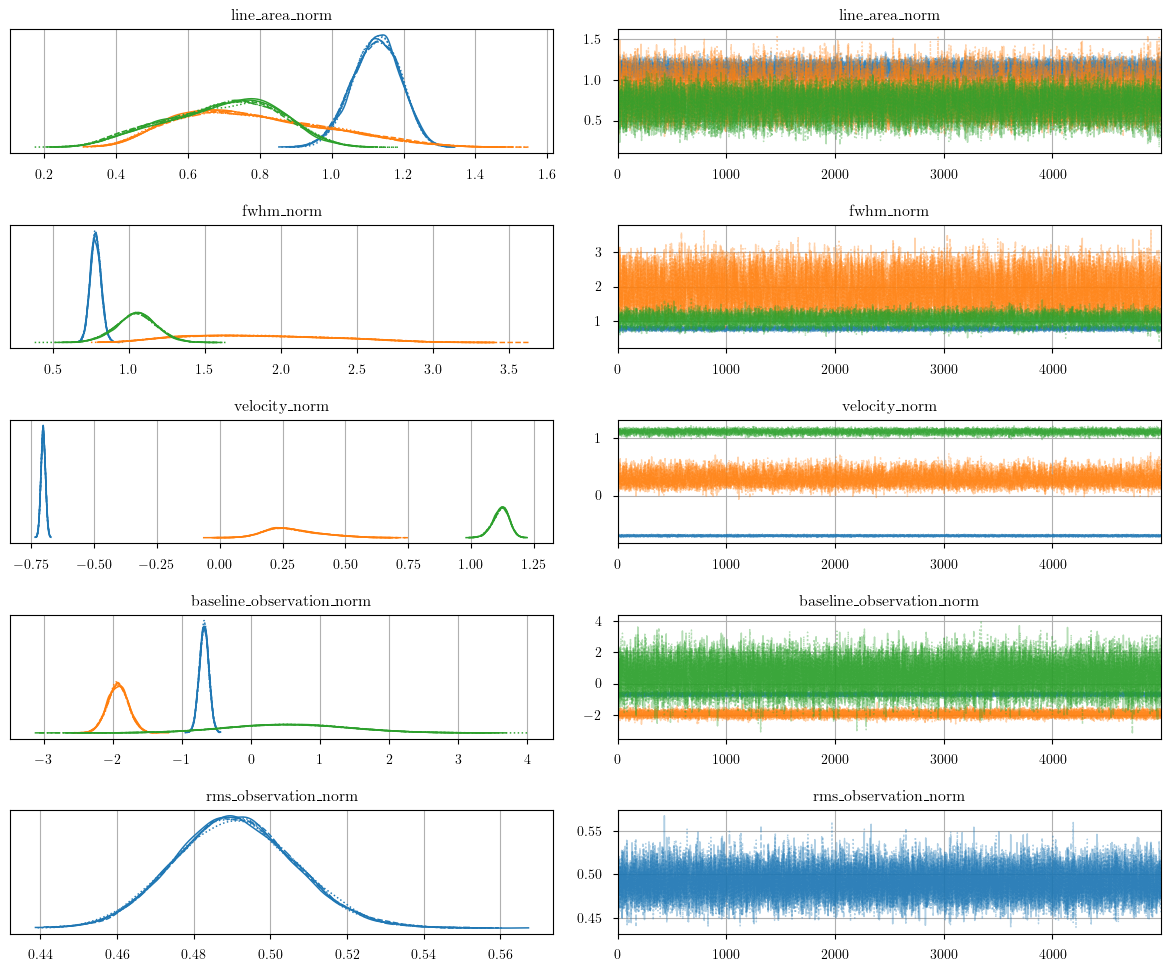

In [20]:
axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

In [21]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
baseline_observation_norm[0]   -0.682   0.069   -0.816   -0.555      0.000   
baseline_observation_norm[1]   -1.931   0.153   -2.224   -1.646      0.001   
baseline_observation_norm[2]    0.531   0.869   -1.093    2.169      0.006   
velocity_norm[0]               -0.703   0.009   -0.720   -0.686      0.000   
velocity_norm[1]                0.292   0.109    0.108    0.508      0.001   
velocity_norm[2]                1.119   0.032    1.057    1.177      0.000   
line_area_norm[0]               1.123   0.066    0.999    1.243      0.001   
line_area_norm[1]               0.784   0.206    0.444    1.173      0.003   
line_area_norm[2]               0.695   0.156    0.394    0.956      0.002   
fwhm_norm[0]                    0.781   0.035    0.716    0.848      0.000   
fwhm_norm[1]                    1.867   0.485    1.066    2.761      0.006   
fwhm_norm[2]                    1.047   0.134    0.783    1.292      0.001   
rms_observation_norm            0.491   0.016    0.461    0.520      0.000   
line_area[0]                  224.659  13.187  199.702  248.609      0.135   
line_area[1]                  156.816  41.198   88.789  234.531      0.533   
line_area[2]                  138.952  31.141   78.758  191.216      0.401   
fwhm[0]                        23.429   1.057   21.482   25.448      0.009   
fwhm[1]                        56.009  14.544   31.968   82.825      0.185   
fwhm[2]                        31.419   4.017   23.501   38.753      0.045   
velocity[0]                   -35.140   0.443  -35.989  -34.316      0.003   
velocity[1]                    14.613   5.442    5.389   25.425      0.063   
velocity[2]                    55.943   1.601   52.873   58.857      0.016   
amplitude[0]                    9.008   0.353    8.351    9.672      0.003   
amplitude[1]                    2.641   0.232    2.212    3.083      0.001   
amplitude[2]                    4.117   0.573    3.017    5.055      0.007   
rms_observation                 0.982   0.031    0.922    1.040      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
baseline_observation_norm[0]    0.000   21039.0   20382.0    1.0  
baseline_observation_norm[1]    0.001   27359.0   20224.0    1.0  
baseline_observation_norm[2]    0.005   21863.0   21921.0    1.0  
velocity_norm[0]                0.000   17277.0   18299.0    1.0  
velocity_norm[1]                0.001    7985.0   12189.0    1.0  
velocity_norm[2]                0.000    9812.0   16180.0    1.0  
line_area_norm[0]               0.000    9545.0   16501.0    1.0  
line_area_norm[1]               0.002    6095.0   13383.0    1.0  
line_area_norm[2]               0.001    6198.0   11387.0    1.0  
fwhm_norm[0]                    0.000   13592.0   18777.0    1.0  
fwhm_norm[1]                    0.004    6342.0   15127.0    1.0  
fwhm_norm[2]                    0.001    8111.0   12483.0    1.0  
rms_observation_norm            0.000   26117.0   19647.0    1.0  
line_area[0]                    0.096    9545.0   16501.0    1.0  
line_area[1]                    0.377    6095.0   13383.0    1.0  
line_area[2]                    0.283    6198.0   11387.0    1.0  
fwhm[0]                         0.006   13592.0   18777.0    1.0  
fwhm[1]                         0.131    6342.0   15127.0    1.0  
fwhm[2]                         0.032    8111.0   12483.0    1.0  
velocity[0]                     0.002   17277.0   18299.0    1.0  
velocity[1]                     0.045    7985.0   12189.0    1.0  
velocity[2]                     0.012    9812.0   16180.0    1.0  
amplitude[0]                    0.002   17383.0   20505.0    1.0  
amplitude[1]                    0.001   25357.0   23145.0    1.0  
amplitude[2]                    0.005    7479.0   14964.0    1.0  
rms_observation                 0.000   26117.0   19647.0    1.0

## `blackjax`

`blackjax` is another JAX-based NUTS sampler, similar to `numpyro`. It can also be run on the GPU.

In [22]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "blackjax",
)

Running window adaptation


Adding log-likelihood to trace


Output()

In [23]:
model.solve()

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [2 1 0]
Chain 1 order: [1 2 0]
Chain 2 order: [1 2 0]
Chain 3 order: [1 0 2]
Chain 4 order: [2 1 0]
Chain 5 order: [2 0 1]
Adopting (first) most common order: [1 2 0]


Sampling: [observation]


Output()

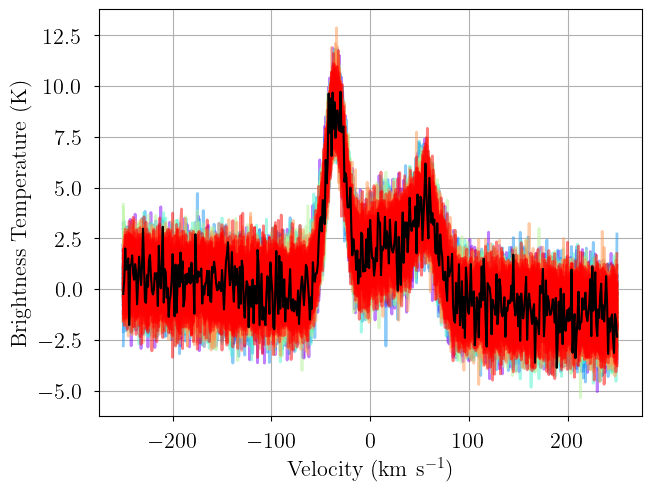

In [24]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

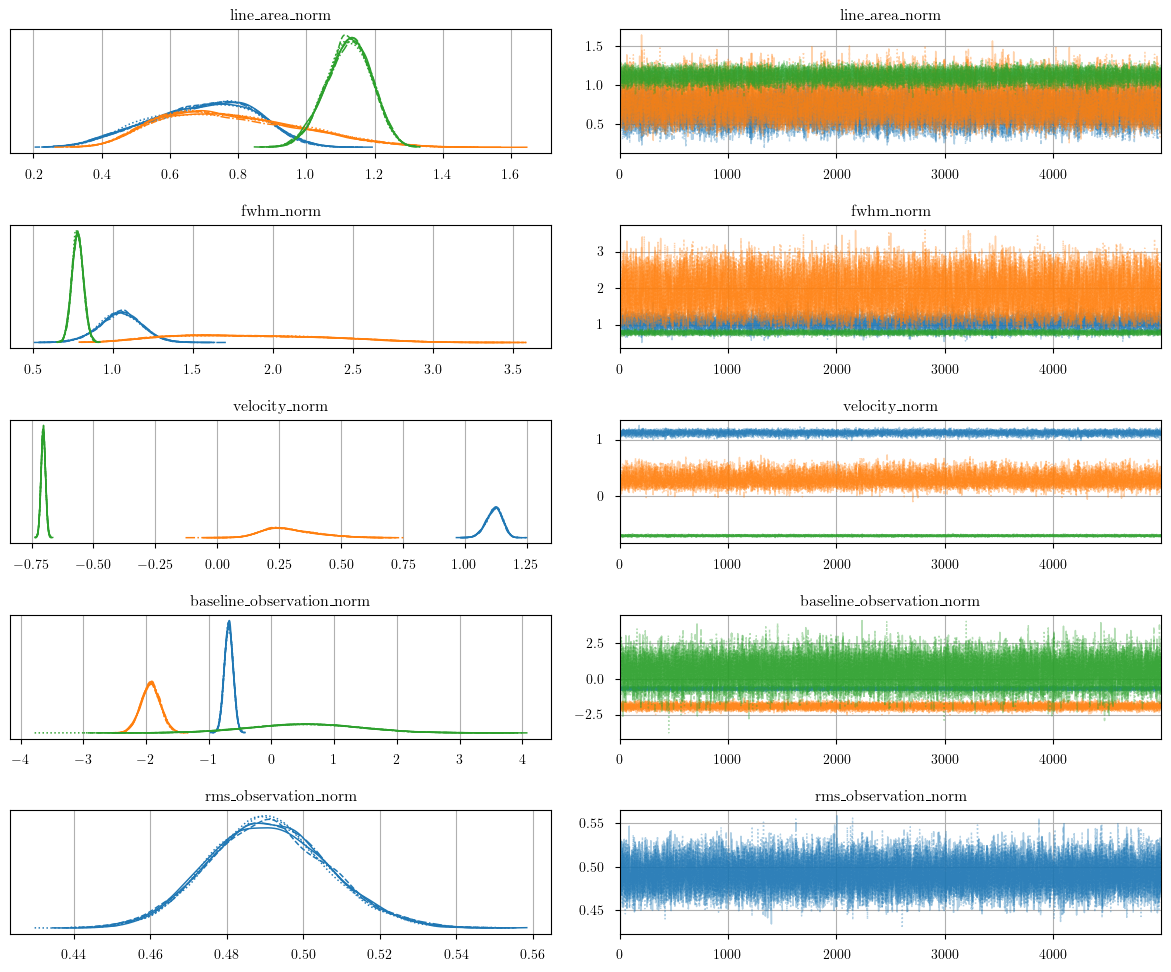

In [26]:
axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

In [27]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
baseline_observation_norm[0]   -0.682   0.069   -0.812   -0.551      0.000   
baseline_observation_norm[1]   -1.929   0.153   -2.207   -1.625      0.001   
baseline_observation_norm[2]    0.543   0.869   -1.117    2.132      0.006   
velocity_norm[0]                1.119   0.032    1.060    1.179      0.000   
velocity_norm[1]                0.292   0.107    0.115    0.506      0.001   
velocity_norm[2]               -0.703   0.009   -0.719   -0.686      0.000   
line_area_norm[0]               0.695   0.153    0.400    0.953      0.002   
line_area_norm[1]               0.783   0.202    0.440    1.155      0.003   
line_area_norm[2]               1.124   0.066    1.000    1.245      0.001   
fwhm_norm[0]                    1.048   0.132    0.794    1.297      0.002   
fwhm_norm[1]                    1.868   0.480    1.044    2.725      0.006   
fwhm_norm[2]                    0.781   0.035    0.717    0.849      0.000   
rms_observation_norm            0.491   0.016    0.463    0.521      0.000   
line_area[0]                  139.081  30.505   79.985  190.566      0.404   
line_area[1]                  156.553  40.339   88.065  231.095      0.533   
line_area[2]                  224.746  13.149  199.970  249.066      0.135   
fwhm[0]                        31.446   3.961   23.834   38.910      0.045   
fwhm[1]                        56.048  14.398   31.331   81.761      0.186   
fwhm[2]                        23.431   1.056   21.497   25.477      0.009   
velocity[0]                    55.954   1.591   52.986   58.930      0.017   
velocity[1]                    14.596   5.327    5.749   25.313      0.063   
velocity[2]                   -35.135   0.439  -35.960  -34.307      0.003   
amplitude[0]                    4.120   0.561    3.064    5.049      0.007   
amplitude[1]                    2.636   0.234    2.189    3.071      0.001   
amplitude[2]                    9.011   0.353    8.344    9.663      0.003   
rms_observation                 0.982   0.031    0.925    1.042      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
baseline_observation_norm[0]    0.000   20252.0   20543.0    1.0  
baseline_observation_norm[1]    0.001   29192.0   21569.0    1.0  
baseline_observation_norm[2]    0.005   21667.0   22045.0    1.0  
velocity_norm[0]                0.000    8841.0   15672.0    1.0  
velocity_norm[1]                0.001    7564.0   12989.0    1.0  
velocity_norm[2]                0.000   16164.0   20405.0    1.0  
line_area_norm[0]               0.001    5822.0   11980.0    1.0  
line_area_norm[1]               0.002    5764.0   13732.0    1.0  
line_area_norm[2]               0.000    9466.0   16854.0    1.0  
fwhm_norm[0]                    0.001    7615.0   12682.0    1.0  
fwhm_norm[1]                    0.004    6058.0   13424.0    1.0  
fwhm_norm[2]                    0.000   14039.0   19543.0    1.0  
rms_observation_norm            0.000   27375.0   20402.0    1.0  
line_area[0]                    0.285    5822.0   11980.0    1.0  
line_area[1]                    0.377    5764.0   13732.0    1.0  
line_area[2]                    0.096    9466.0   16854.0    1.0  
fwhm[0]                         0.032    7615.0   12682.0    1.0  
fwhm[1]                         0.132    6058.0   13424.0    1.0  
fwhm[2]                         0.006   14039.0   19543.0    1.0  
velocity[0]                     0.012    8841.0   15672.0    1.0  
velocity[1]                     0.045    7564.0   12989.0    1.0  
velocity[2]                     0.002   16164.0   20405.0    1.0  
amplitude[0]                    0.005    7180.0   15164.0    1.0  
amplitude[1]                    0.001   24935.0   24036.0    1.0  
amplitude[2]                    0.002   17581.0   20459.0    1.0  
rms_observation                 0.000   27375.0   20402.0    1.0

## Sequential Monte Carlo

[Sequential Monte Carlo](https://www.pymc.io/projects/examples/en/latest/samplers/SMC2_gaussians.html) is a sampling strategy that overcomes the issues of multi-modal posterior distributions. In this case, where our model is a simple mixture of Gaussians, our posterior is highly multi-modal: chains could "collapse" to a single mode, and there is also the labeling degeneracy. We did not encounter any problems with the default MCMC sampling methods described in the other notebooks, primarily because we *initialized* the sampler using strong constraints from the variational inference initialization.

SMC has two hyperparameters: `draws`, the number of posterior draws (per stage), and `threshold`, which controls the tempering process between stages. Increasing these parameters will help with sampling from complicated models.

In [28]:
model.sample_smc(
    draws = 2_000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8,
    threshold = 0.75, # increase threshold from default (0.5)
)

Initializing SMC sampler...
Sampling 8 chains in 8 jobs


Output()

/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: 
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will 
likely lead to a deadlock.
  self.pid = os.fork()

Adding log-likelihood to trace


Output()

In [29]:
model.solve()

GMM converged to unique solution
2 of 8 chains appear converged.
Label order mismatch in solution 0
Chain 0 order: [0 2 1]
Chain 5 order: [2 0 1]
Adopting (first) most common order: [0 2 1]


Something doesn't look right! Let's investigate by looking at the posterior predictive samples and the trace.

Sampling: [observation]


Output()

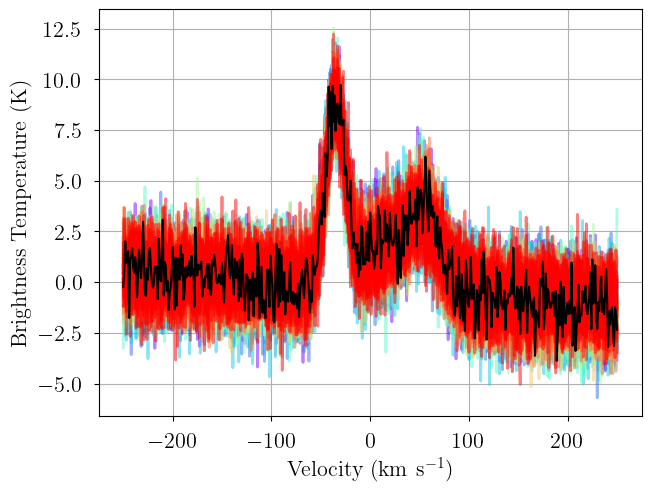

In [30]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

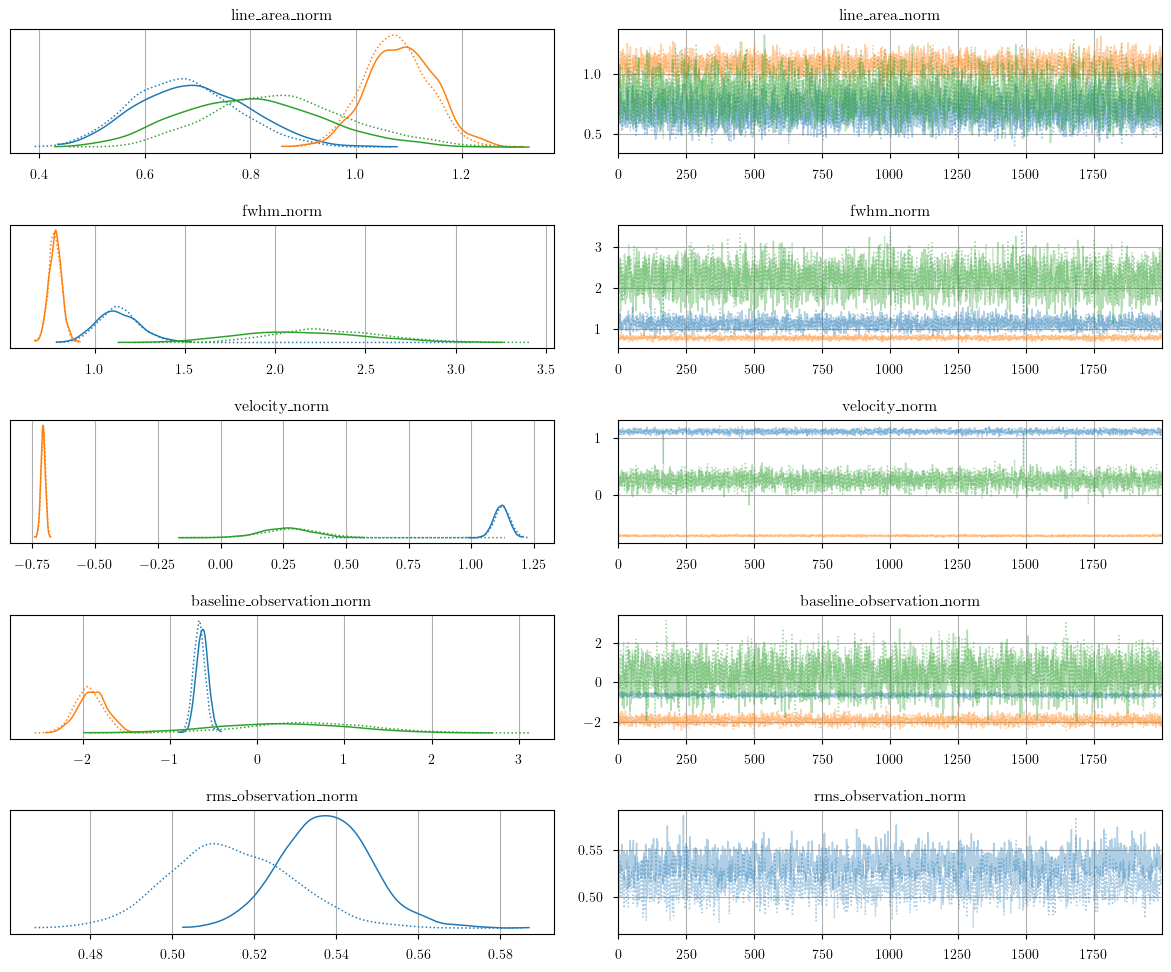

In [31]:
axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

The model has clearly not converged. The issue is actually quite subtle: due to the labeling degeneracy (i.e., the order of the clouds doesn't matter for this model), a single chain may re-order the clouds while sampling, thus causing the assumptions of SMC to break down. For this model, we can overcome this problem by *enforcing* an order on the clouds. The model `GaussNoiseModel` has an option to do just this: `add_priors(ordered=True)`. Note that this changes the definition of the prior distribution on `velocity`. The clouds are *ordered* by increasing velocity, thus breaking the labeling degeneracy. Note that this only works here because our model does not intrinsically depend on the order of the clouds. This is generally true for optically thin emission, but not necessarily true if there is optically thick emission (i.e., self-absorption).

In [32]:
model = GaussNoiseModel(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [-100.0, 20.0], # lower limit and mode of k=2 gamma distribution on velocity OFFSET between clouds (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
    ordered = True, # enforce ordered velocities
)
model.add_likelihood()

Sampling: [baseline_observation_norm, fwhm_norm, line_area_norm, observation, rms_observation_norm, velocity_norm]


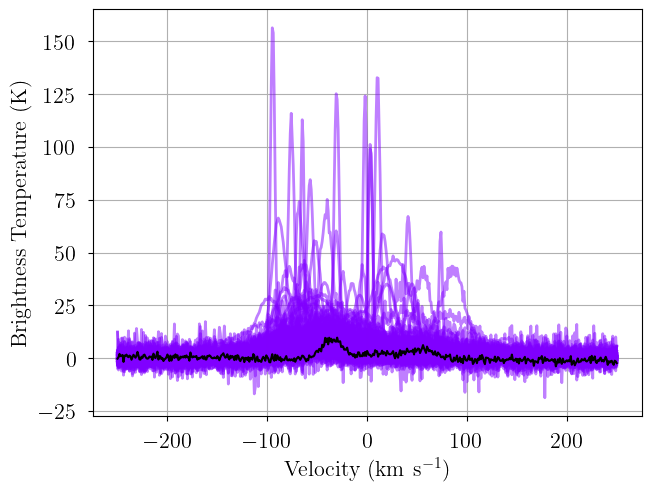

In [33]:
# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [34]:
model.sample_smc(
    draws = 2_000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8,
    threshold = 0.75, # increase threshold from default (0.5)
)

Initializing SMC sampler...
Sampling 8 chains in 8 jobs


Output()

/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: 
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will 
likely lead to a deadlock.
  self.pid = os.fork()

Adding log-likelihood to trace


Output()

In [35]:
model.solve()

GMM converged to unique solution
7 of 8 chains appear converged.


Sampling: [observation]


Output()

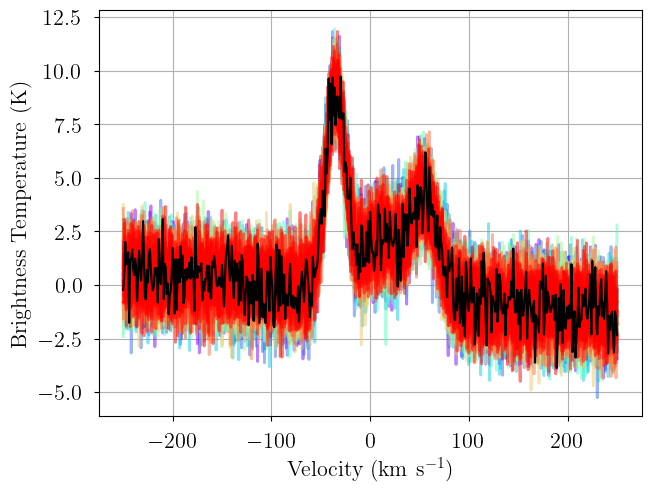

In [36]:
posterior = model.sample_posterior_predictive(
    thin=100,  # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

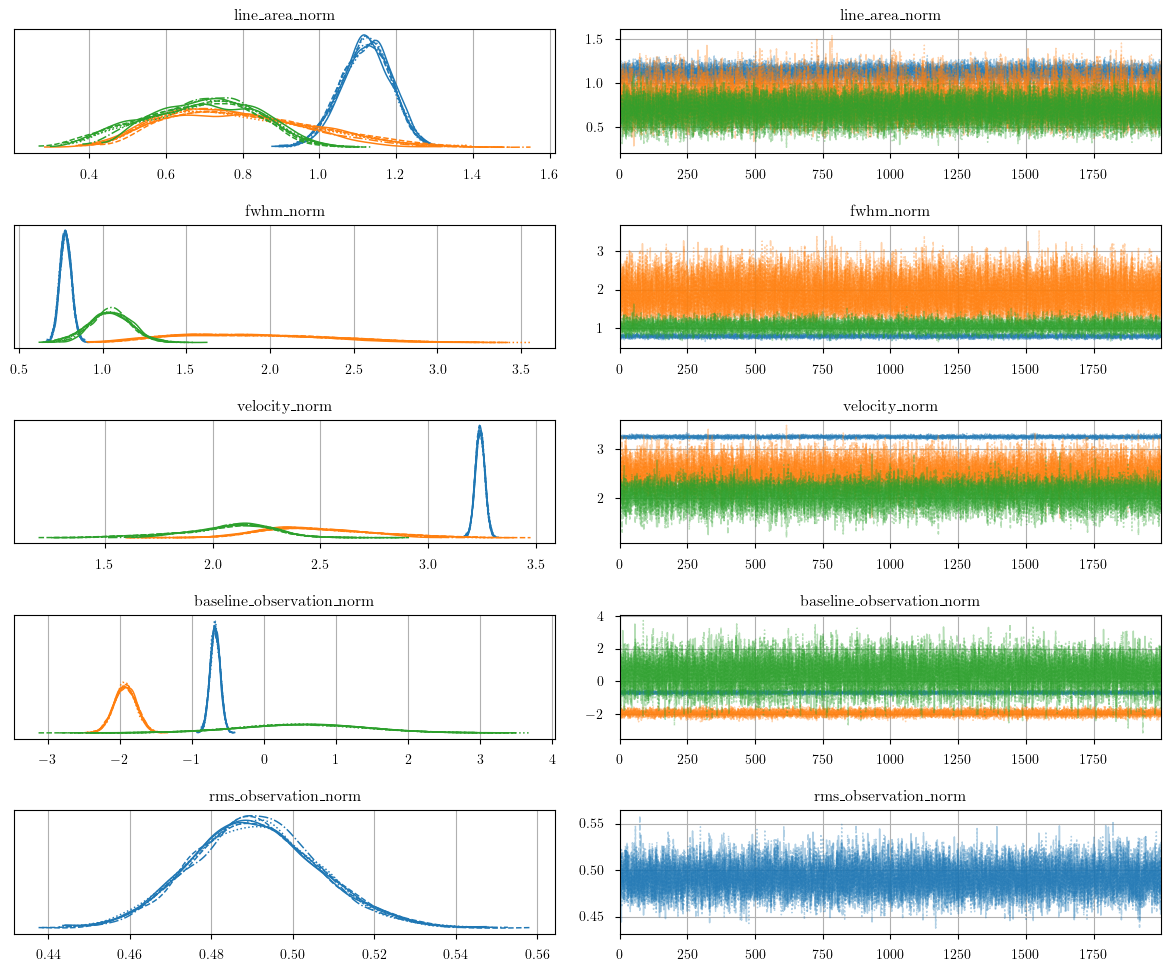

In [37]:
axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

In [38]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
baseline_observation_norm[0]   -0.681   0.069   -0.810   -0.552      0.001   
baseline_observation_norm[1]   -1.930   0.152   -2.221   -1.650      0.001   
baseline_observation_norm[2]    0.521   0.867   -1.133    2.141      0.007   
line_area_norm[0]               1.121   0.065    0.998    1.238      0.001   
line_area_norm[1]               0.788   0.188    0.485    1.153      0.002   
line_area_norm[2]               0.692   0.142    0.423    0.933      0.001   
fwhm_norm[0]                    0.780   0.035    0.714    0.844      0.000   
fwhm_norm[1]                    1.885   0.449    1.127    2.686      0.004   
fwhm_norm[2]                    1.045   0.123    0.812    1.276      0.001   
velocity_norm[0]                3.242   0.022    3.202    3.283      0.000   
velocity_norm[1]                2.484   0.248    2.056    2.963      0.002   
velocity_norm[2]                2.078   0.209    1.645    2.435      0.002   
rms_observation_norm            0.491   0.016    0.460    0.519      0.000   
line_area[0]                  224.121  12.970  199.622  247.574      0.112   
line_area[1]                  157.550  37.580   96.906  230.624      0.393   
line_area[2]                  138.449  28.325   84.644  186.604      0.277   
fwhm[0]                        23.387   1.036   21.416   25.315      0.009   
fwhm[1]                        56.555  13.458   33.810   80.590      0.126   
fwhm[2]                        31.355   3.702   24.361   38.277      0.033   
velocity[0]                   -35.160   0.434  -35.967  -34.336      0.004   
velocity[1]                    14.517   4.959    6.357   24.641      0.047   
velocity[2]                    56.080   1.500   53.239   58.838      0.014   
amplitude[0]                    9.003   0.351    8.333    9.648      0.003   
amplitude[1]                    2.627   0.224    2.210    3.049      0.002   
amplitude[2]                    4.120   0.531    3.118    5.030      0.005   
rms_observation                 0.982   0.031    0.921    1.038      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
baseline_observation_norm[0]    0.000   13671.0   13300.0   1.00  
baseline_observation_norm[1]    0.001   13802.0   13437.0   1.00  
baseline_observation_norm[2]    0.005   13893.0   13170.0   1.00  
line_area_norm[0]               0.000   13509.0   13685.0   1.00  
line_area_norm[1]               0.001   10427.0   10161.0   1.01  
line_area_norm[2]               0.001    9639.0    9316.0   1.01  
fwhm_norm[0]                    0.000   13282.0   13731.0   1.00  
fwhm_norm[1]                    0.003   11309.0   10722.0   1.00  
fwhm_norm[2]                    0.001   12474.0    9866.0   1.00  
velocity_norm[0]                0.000   12938.0   12922.0   1.00  
velocity_norm[1]                0.002   10916.0    7066.0   1.00  
velocity_norm[2]                0.001   11750.0    7083.0   1.00  
rms_observation_norm            0.000   12981.0   13544.0   1.00  
line_area[0]                    0.079   13509.0   13685.0   1.00  
line_area[1]                    0.279   10427.0   10161.0   1.01  
line_area[2]                    0.196    9639.0    9316.0   1.01  
fwhm[0]                         0.006   13282.0   13731.0   1.00  
fwhm[1]                         0.089   11309.0   10722.0   1.00  
fwhm[2]                         0.024   12474.0    9866.0   1.00  
velocity[0]                     0.003   12938.0   12922.0   1.00  
velocity[1]                     0.034   11016.0    2709.0   1.00  
velocity[2]                     0.010   12179.0   11430.0   1.00  
amplitude[0]                    0.002   13744.0   13722.0   1.00  
amplitude[1]                    0.001   13435.0   12792.0   1.00  
amplitude[2]                    0.004   11293.0    9276.0   1.00  
rms_observation                 0.000   12981.0   13544.0   1.00